**Problem background:**
- Pneumonia is an infection in one or both lungs. Bacteria, viruses, and fungi cause it.
-	Infection causes Inflammation in the air sacs (alveoli)  in your lungs 
-	Alveoli,  take up the oxygen you breathe in and keep your body going. Although they’re microscopic, alveoli are the workhorses of your respiratory system.
-	480 million alveoli, located at the end of bronchial tubes. When you breathe in, the alveoli expand to take in oxygen. When you breathe out, the alveoli shrink to expel carbon dioxide.
- following test are performed for the diagonis 
  - Chest X-ray / CT scan
  - Blood test
  - Bronchoscope
  
- Pneumonia can affect anyone. But the two age groups at highest risk are:

  - Children who are 2 years old or younger
  - People who are age 65 or older

  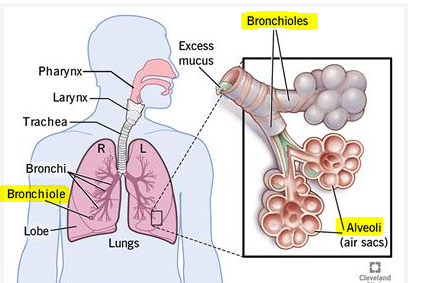

  


**Problem Statement**- Pneumonia detection 

**Why ?**
 - Diagnosis is a complex process and requred a highely trained specialist 
 - Cost informed in the diagnosis

**What ?** 
  - Create a ML model which read the CXR images and locate the postion of the inflammation 

**How ?**

 - Approach - 1 ( Feature extraction ( DNN ) + Classification ( ML )
  - stacking models - Image classification ( to check is affected by Pneumonia or not ) and If the patient affected by Pneumonia then inputs are passed to second model to locate the inflammation
 - Approach 2 - Single model to locate the inflammation. ( Automl - autogluon , tensorflow - objectdetection )  

 - Metrics - Recall will be the evaluation metrics ( Since it's important to indentify the person affected by Pneumonia )

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Importing lib

In [2]:
pip install pydicom

     |████████████████████████████████| 1.9 MB 12.4 MB/s 


In [21]:
import pandas as pd
import numpy as np
import os
import pydicom as dicom
from pydicom.pixel_data_handlers.util import apply_voi_lut

import cv2


import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from PIL import Image,ImageDraw,ImageOps,ImageFilter


import tensorflow as tf 
from tensorflow.keras.layers import MaxPool2D 


In [4]:
RANDOM_SEED = 123

### setting folder path

In [5]:
DATA_ROOT_PATH = "/content/drive/MyDrive/GreatLearning/Captone_project/Pneumonia _DS/"
META_DATA = os.path.join(DATA_ROOT_PATH,"stage_2_detailed_class_info.csv/stage_2_detailed_class_info.csv")
TRAIN_LABEL = os.path.join(DATA_ROOT_PATH,"stage_2_train_labels.csv/stage_2_train_labels.csv")
TRAIN_FOLDER = os.path.join(DATA_ROOT_PATH,"stage_2_train_images")
TEST_FOLDER = os.path.join(DATA_ROOT_PATH,"stage_2_test_images")

DATA_ROOT_PATH,META_DATA, TRAIN_LABEL,TRAIN_FOLDER,TEST_FOLDER

('/content/drive/MyDrive/GreatLearning/Captone_project/Pneumonia _DS/',
 '/content/drive/MyDrive/GreatLearning/Captone_project/Pneumonia _DS/stage_2_detailed_class_info.csv/stage_2_detailed_class_info.csv',
 '/content/drive/MyDrive/GreatLearning/Captone_project/Pneumonia _DS/stage_2_train_labels.csv/stage_2_train_labels.csv',
 '/content/drive/MyDrive/GreatLearning/Captone_project/Pneumonia _DS/stage_2_train_images',
 '/content/drive/MyDrive/GreatLearning/Captone_project/Pneumonia _DS/stage_2_test_images')

### Reading Data

In [6]:
meta_data = pd.read_csv(META_DATA)
meta_data.head()

patientId  ... Unnamed: 3
0  0004cfab-14fd-4e49-80ba-63a80b6bddd6  ...        NaN
1  00313ee0-9eaa-42f4-b0ab-c148ed3241cd  ...        NaN
2  00322d4d-1c29-4943-afc9-b6754be640eb  ...        NaN
3  003d8fa0-6bf1-40ed-b54c-ac657f8495c5  ...        NaN
4  00436515-870c-4b36-a041-de91049b9ab4  ...        NaN

[5 rows x 4 columns]

In [7]:
train_data = pd.read_csv(TRAIN_LABEL)
train_data.head()

patientId      x      y  width  height  Target
0  0004cfab-14fd-4e49-80ba-63a80b6bddd6    NaN    NaN    NaN     NaN       0
1  00313ee0-9eaa-42f4-b0ab-c148ed3241cd    NaN    NaN    NaN     NaN       0
2  00322d4d-1c29-4943-afc9-b6754be640eb    NaN    NaN    NaN     NaN       0
3  003d8fa0-6bf1-40ed-b54c-ac657f8495c5    NaN    NaN    NaN     NaN       0
4  00436515-870c-4b36-a041-de91049b9ab4  264.0  152.0  213.0   379.0       1

### Exploratory data analysis

#### checking data distribution

Shape of data (26685, 4)
----------------

No Lung Opacity / Not Normal    11821
Normal                           8851
Lung Opacity                     6013
Name: class, dtype: int64
----------------



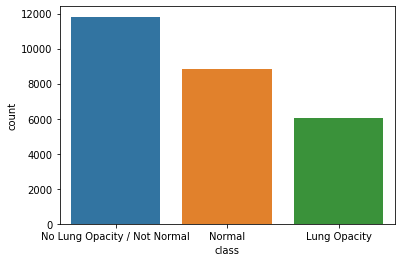

In [8]:
### Distribution od the class
meta_data.drop_duplicates(inplace=True)
print("Shape of data",meta_data.shape)
print("----------------\n")

print(meta_data["class"].value_counts())
print("----------------\n")

sns.countplot(data=meta_data,x="class")

Shape of data (30227, 6)
----------------

0    20672
1     9555
Name: Target, dtype: int64
----------------



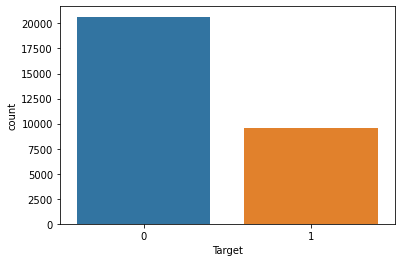

In [9]:
### Distribution of the class
train_data.drop_duplicates(inplace=True)
print("Shape of data",train_data.shape)
print("----------------\n")

print(train_data["Target"].value_counts())
print("----------------\n")

sns.countplot(data=train_data,x="Target")

In [10]:
train_data = train_data.join(meta_data.set_index("patientId"),on="patientId")
print("Shape after merge", train_data.shape)
train_data.head()

Shape after merge (30229, 9)


patientId      x  ...  Unnamed: 2  Unnamed: 3
0  0004cfab-14fd-4e49-80ba-63a80b6bddd6    NaN  ...         NaN         NaN
1  00313ee0-9eaa-42f4-b0ab-c148ed3241cd    NaN  ...         NaN         NaN
2  00322d4d-1c29-4943-afc9-b6754be640eb    NaN  ...         NaN         NaN
3  003d8fa0-6bf1-40ed-b54c-ac657f8495c5    NaN  ...         NaN         NaN
4  00436515-870c-4b36-a041-de91049b9ab4  264.0  ...         NaN         NaN

[5 rows x 9 columns]

#### prepare file name list

In [12]:
train_img_list = os.listdir(TRAIN_FOLDER)
print("Total train image",len(train_img_list))

test_img_list = os.listdir(TEST_FOLDER)
print("Total train image",len(test_img_list))


train_file_ext = set()
for train_img in train_img_list:
  _,extension = os.path.splitext(train_img)
  train_file_ext.add(extension)


test_file_ext = set()
for test_img in test_img_list:
  _,extension = os.path.splitext(test_img)
  test_file_ext.add(extension)  


print("Available file extension on train", train_file_ext)
print("Available file extension on test", test_file_ext)



Total train image 26694
Total train image 3000
Available file extension on train {'.dcm'}
Available file extension on test {'.dcm'}


#### Update file path to pandas

In [13]:
patientId_list = []
file_path_list = []
train_test_label = []

for filename in train_img_list:
  patientid,extension = os.path.splitext(filename)
  patientId_list.append(patientid)
  file_path_list.append(os.path.join(TRAIN_FOLDER,filename))
  train_test_label.append("Train")


for filename in test_img_list:
  patientid,extension = os.path.splitext(filename)
  patientId_list.append(patientid)
  file_path_list.append(os.path.join(TEST_FOLDER,filename))
  train_test_label.append("Test")


print("length of list ",len(patientId_list),len(file_path_list) )

file_data = pd.DataFrame(columns=["patientId","filepath"])
file_data["patientId"] = patientId_list
file_data["filepath"] = file_path_list
file_data["Train_or_Test"] = train_test_label
print("file Path dataframe shape",file_data.shape)
file_data.head()



length of list  29694 29694
file Path dataframe shape (29694, 3)


patientId  ... Train_or_Test
0  f7661af4-f66e-4867-a3d6-7e1fab5aabb2  ...         Train
1  f7b557b1-623e-4466-a60b-ada96f7ba8ff  ...         Train
2  f7a60085-3653-4011-b420-ed3a92a4a80a  ...         Train
3  f79bfdae-858b-404b-b25f-7acf681804da  ...         Train
4  f7909c0c-c9f0-4c93-be7f-113926850ac3  ...         Train

[5 rows x 3 columns]

In [14]:
train_data = train_data.join(file_data.set_index("patientId"),on="patientId")
print("Shape of dataframe after merge",train_data.shape)
train_data.head()

Shape of dataframe after merge (30229, 11)


patientId  ...  Train_or_Test
0  0004cfab-14fd-4e49-80ba-63a80b6bddd6  ...          Train
1  00313ee0-9eaa-42f4-b0ab-c148ed3241cd  ...          Train
2  00322d4d-1c29-4943-afc9-b6754be640eb  ...          Train
3  003d8fa0-6bf1-40ed-b54c-ac657f8495c5  ...          Train
4  00436515-870c-4b36-a041-de91049b9ab4  ...          Train

[5 rows x 11 columns]

In [ ]:
# file_name = os.path.join(TRAIN_FOLDER,train_img_list[20])
# ds = dicom.read_file(file_name)
# ds.PatientSex,ds.PatientAge,ds.ViewPosition,ds.PatientID

#### visualization of xray with bounding box

In [15]:
def read_xray(path, voi_lut = True, fix_monochrome = True):
    img = dicom.dcmread(path)    
    # VOI LUT (if available by DICOM device) is used to transform raw DICOM data to "human-friendly" view
    if voi_lut:
        data = apply_voi_lut(img.pixel_array, img)
    else:
        data = img.pixel_array               
    # depending on this value, X-ray may look inverted - fix that:
    if fix_monochrome and img.PhotometricInterpretation == "MONOCHROME1":
        data = np.amax(data) - data        
    data = data - np.min(data)
    data = data / np.max(data)
    data = (data * 255).astype(np.uint8)        
    return data

In [16]:
# Visualize the image 
infected_id = train_data.query("Target == 1").sample(n=9,random_state = RANDOM_SEED).index
not_infected_id = train_data.query("Target == 0").sample(n=9,random_state = RANDOM_SEED).index

In [98]:
def max_pool(img):
  x = tf.reshape(img, [1, 1024, 1024, 1])
  max_pool_2d = tf.keras.layers.MaxPooling2D(pool_size=(32,32),strides=(1, 1), padding='same')
  x = max_pool_2d(x)
  x = np.reshape(x, (x.shape[1],x.shape[2]))
  return x


def plot_images(id_list):
  for i in range(6): 
    fig,ax = plt.subplots(nrows=1,ncols=5,figsize=(25, 5))
    index =  id_list[i]  
    file_name = train_data.loc[index]["filepath"]
    img = read_xray(file_name)
    ax[0].imshow(img,"bone") 
    colormap = sns.color_palette("YlOrBr")   
    sns.heatmap(img,ax=ax[1],cbar=False,cmap=colormap)
    sns.heatmap(max_pool(img),ax=ax[2],cbar=False,cmap=colormap)
    pil_img = Image.fromarray(img)
    pil_img =  pil_img.filter(ImageFilter.BoxBlur(10))
    ax[3].imshow(pil_img,"bone") 

    clahe = cv2.createCLAHE(clipLimit = 5)
    clahe_img = clahe.apply(img) + 30
    ax[4].imshow(clahe_img,"bone") 


    if train_data.loc[index]["Target"] == 1:
        x = int(train_data.loc[index]["x"])
        y = int(train_data.loc[index]["y"])
        width = int(train_data.loc[index]["width"])
        height = int(train_data.loc[index]["height"])
        ax[0].add_patch(Rectangle((x,y), width,height, linewidth=2, fill=False,color="black"))   
        ax[1].add_patch(Rectangle((x,y), width,height, linewidth=2, fill=False,color="black"))
        ax[2].add_patch(Rectangle((x,y), width,height, linewidth=2, fill=False,color="black"))
        ax[3].add_patch(Rectangle((x,y), width,height, linewidth=2, fill=False,color="black"))
        ax[4].add_patch(Rectangle((x,y), width,height, linewidth=2, fill=False,color="black"))
        
    ax[1].axis("off")    
    ax[2].axis("off")
    ax[3].axis("off")
    ax[4].axis("off")

    ax[0].title.set_text("original Image")
    ax[1].title.set_text("Heat Map")
    ax[2].title.set_text("Max pooling + Heat Map")
    ax[3].title.set_text("Box blur")
    ax[4].title.set_text("CLAHE")
    fig.suptitle("{} - {} /// {} - {} \n".format("Patient ID",train_data.loc[index]["patientId"],"class ",train_data.loc[index]["class"]))
    plt.show()

In [61]:
# print(infected_id)
# file_name = train_data.loc[20771]["filepath"]
# img = read_xray(file_name)
# pil_img = Image.fromarray(img)
# pil_img =  pil_img.filter(ImageFilter.SHARPEN)
# #sns.heatmap(pil_img)
# plt.imshow(pil_img,"bone")

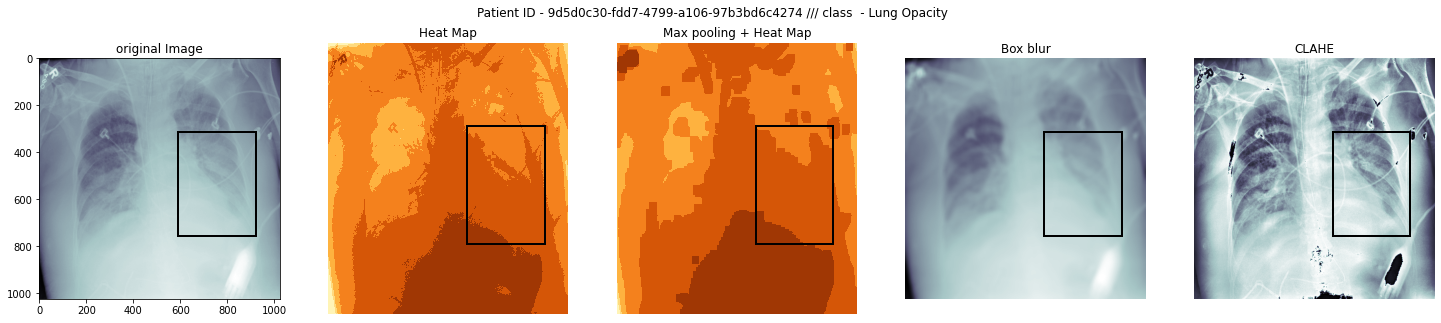

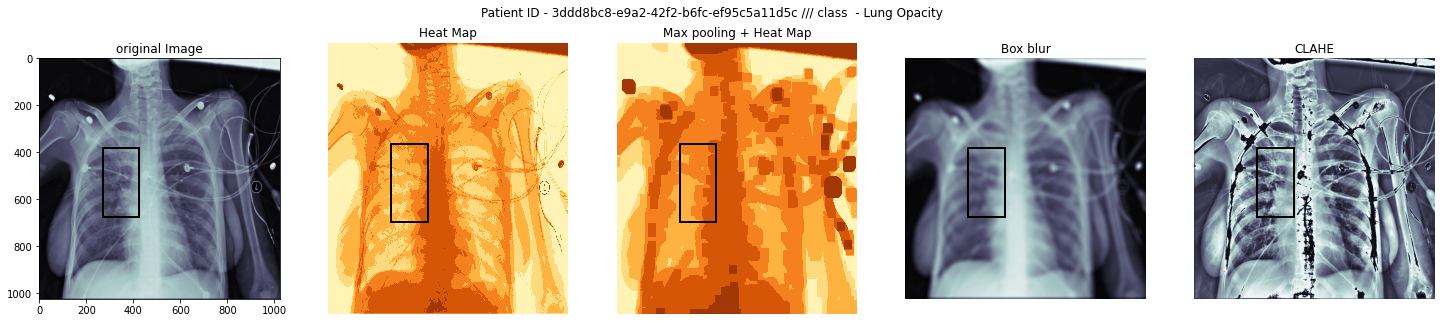

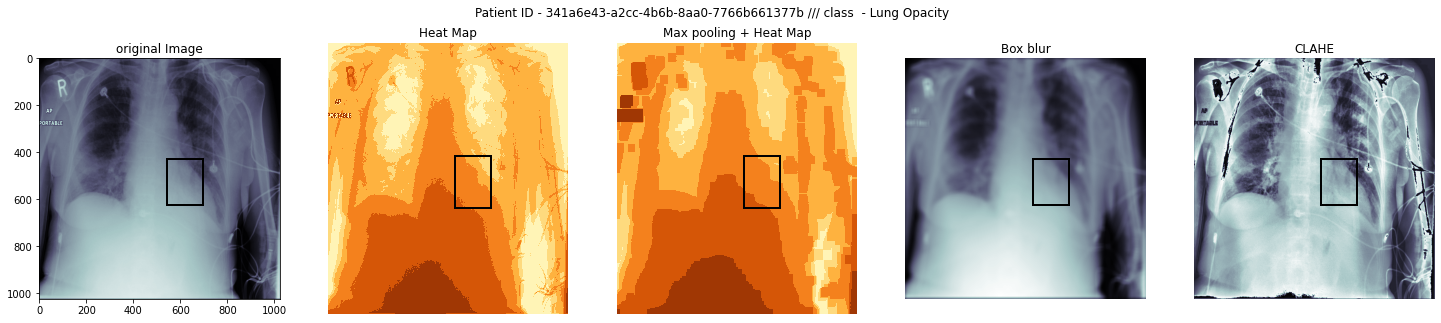

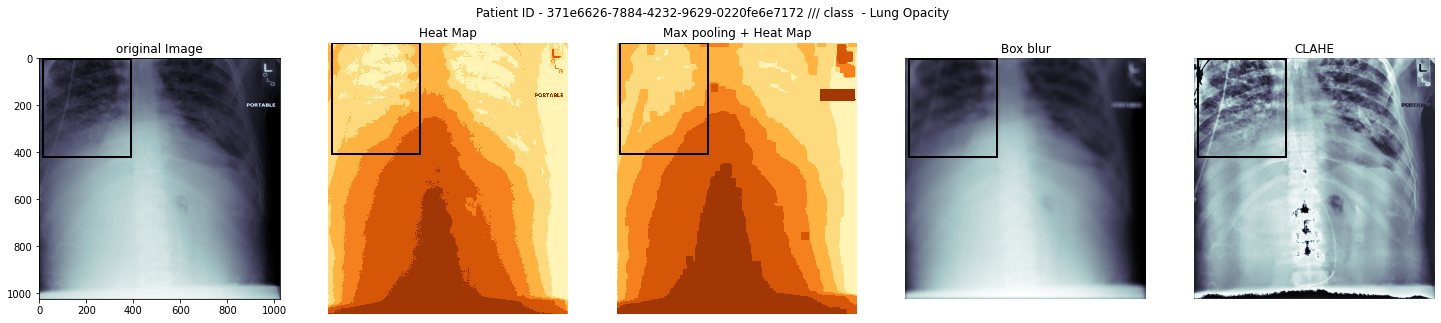

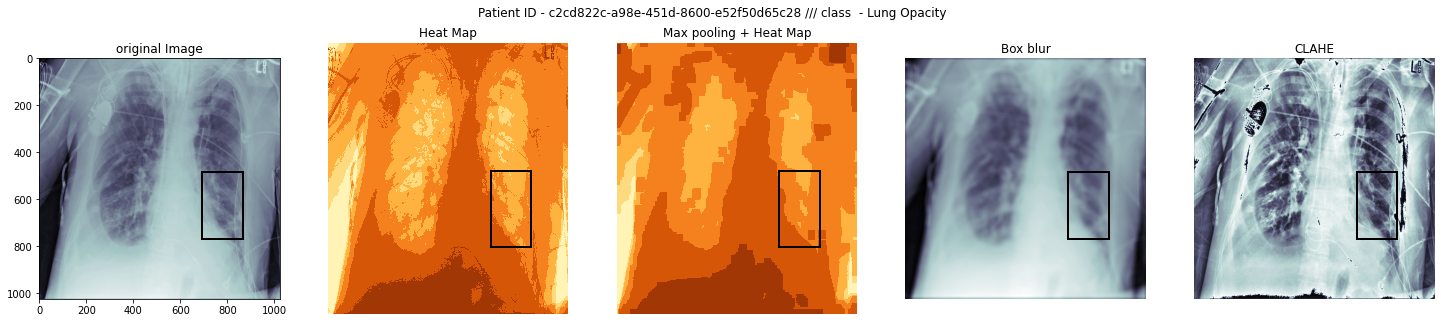

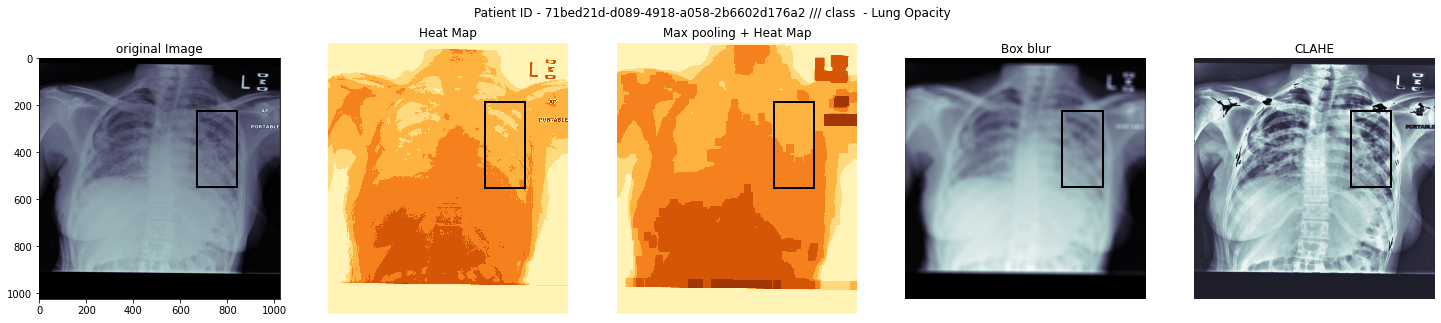

In [99]:
plot_images(infected_id)

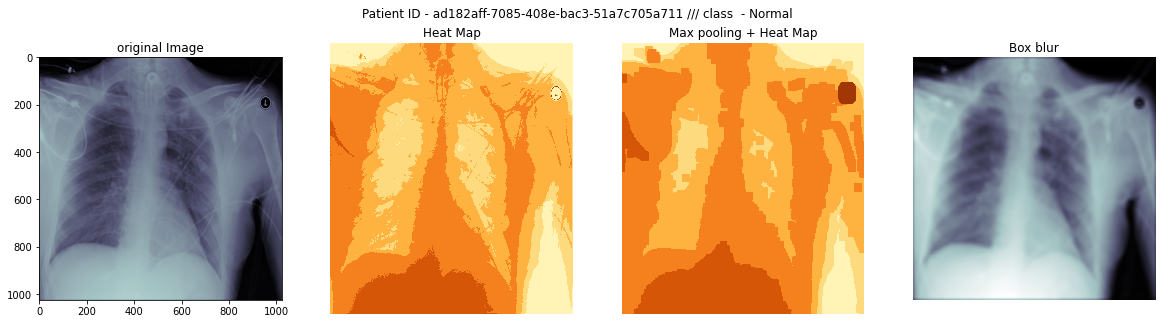

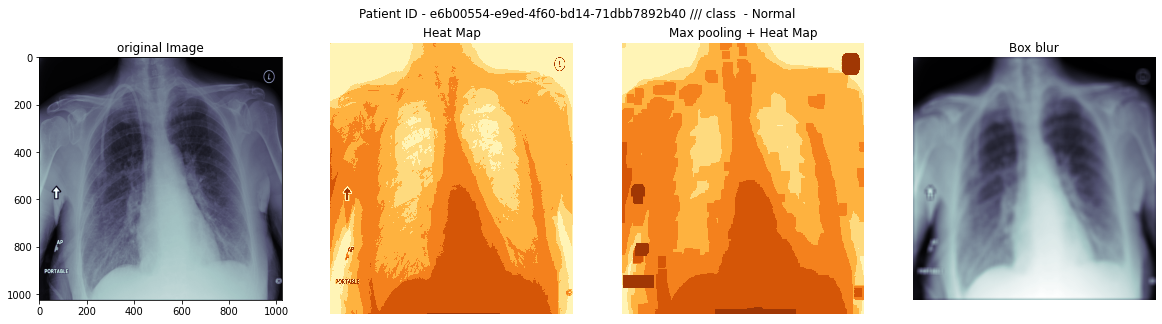

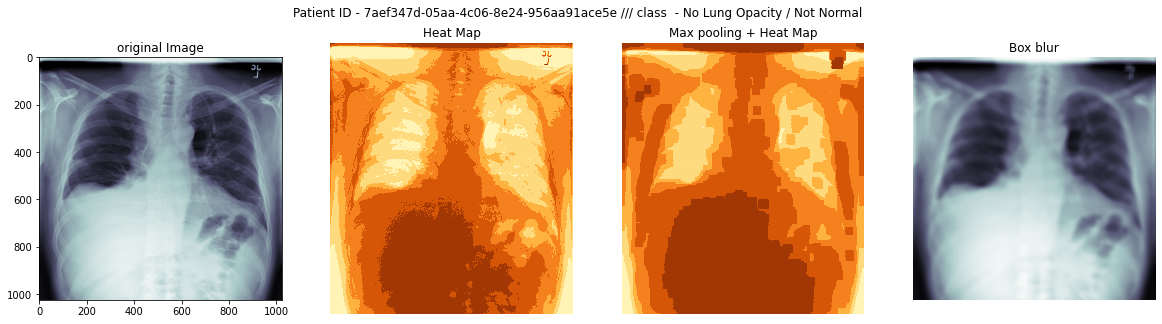

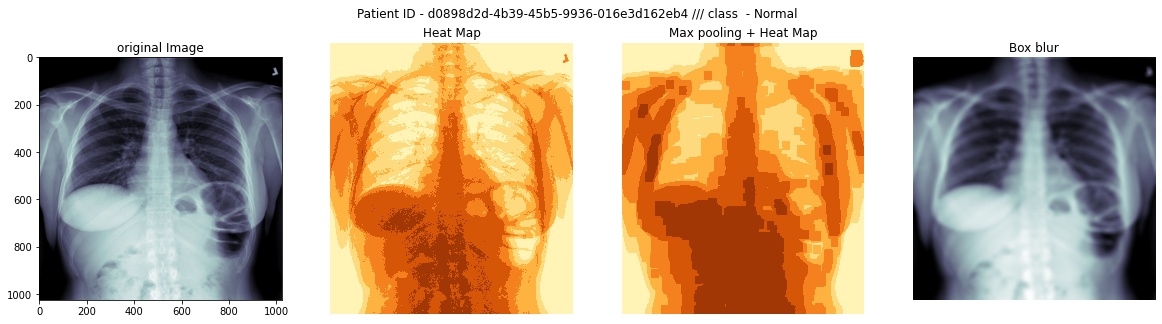

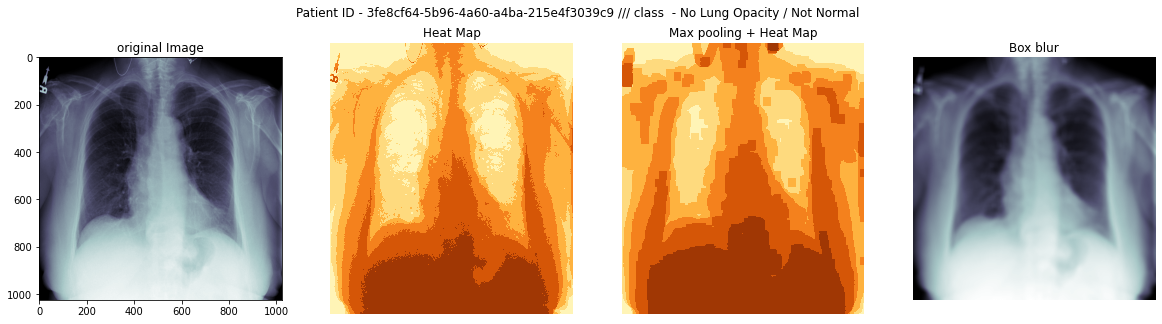

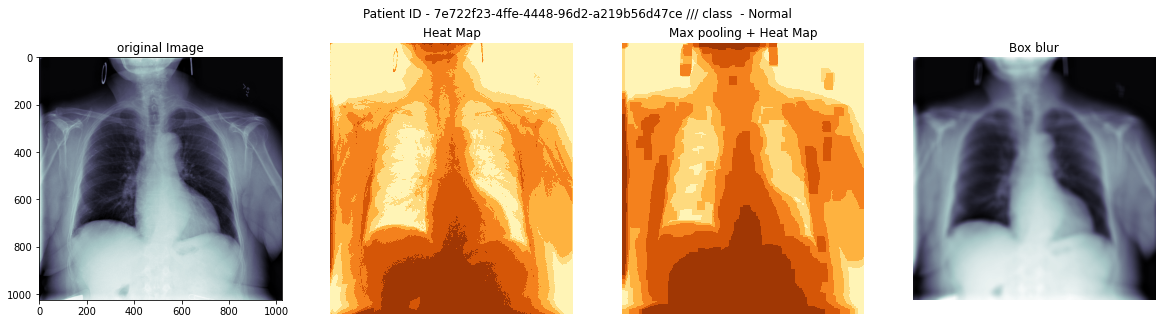

In [71]:
plot_images(not_infected_id)

#### Scatter plot for the x & y 
 - to chect is there any outlier on the x & y

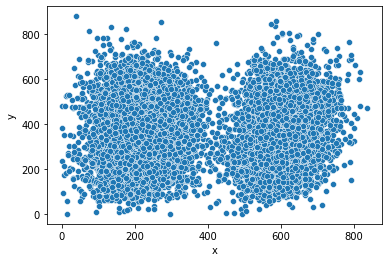

In [72]:
sns.scatterplot(data=train_data.query("Target == 1"),x="x",y="y")

#### How big is the affected area 

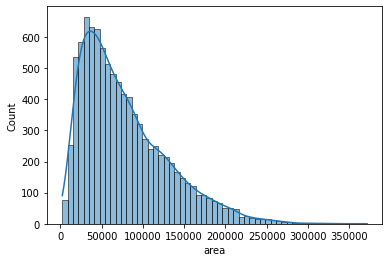

In [73]:
 train_data["area"] = train_data["width"] * train_data["height"]
 sns.histplot(data=train_data.query("Target == 1"),x="area",kde=True)

In [74]:
train_data[["x",'y',"width","height","area"]].describe()

x            y        width       height           area
count  9557.000000  9557.000000  9557.000000  9557.000000    9557.000000
mean    394.052422   366.818667   218.472324   329.266611   77521.825259
std     204.571006   148.933731    59.284594   157.734511   51802.449573
min       2.000000     2.000000    40.000000    45.000000    2320.000000
25%     207.000000   249.000000   177.000000   203.000000   37541.000000
50%     324.000000   365.000000   217.000000   298.000000   64829.000000
75%     594.000000   478.000000   259.000000   438.000000  106470.000000
max     835.000000   881.000000   528.000000   942.000000  371184.000000

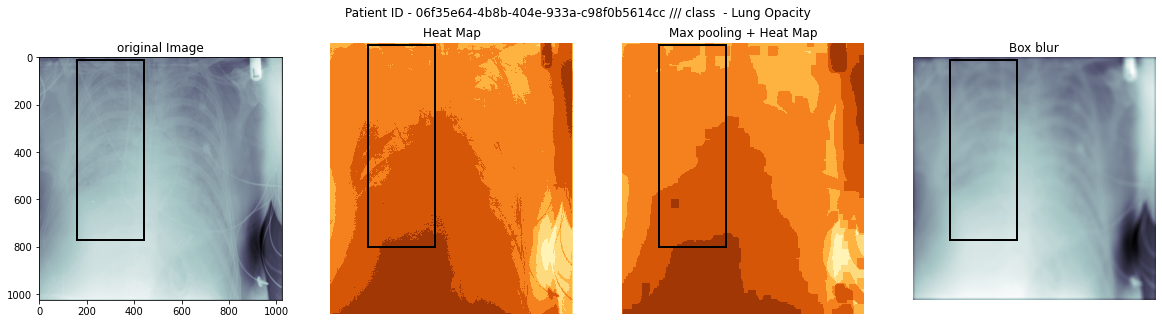

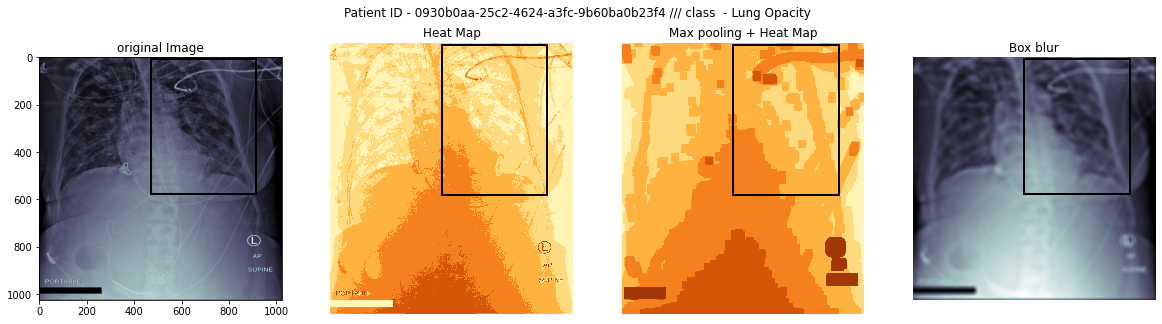

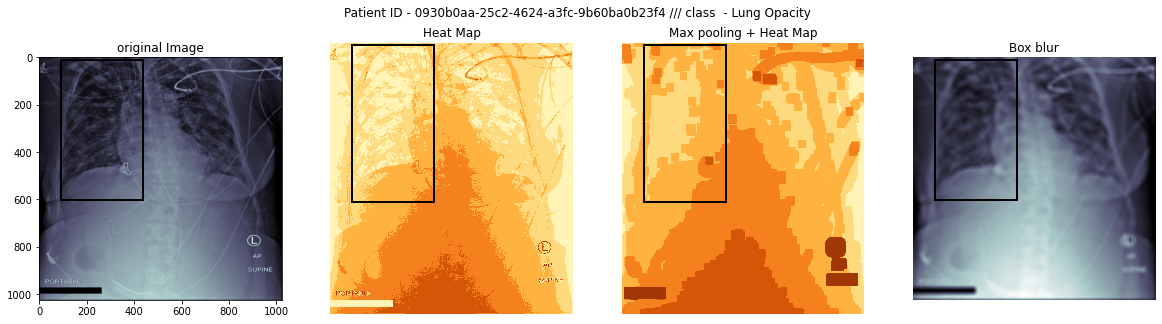

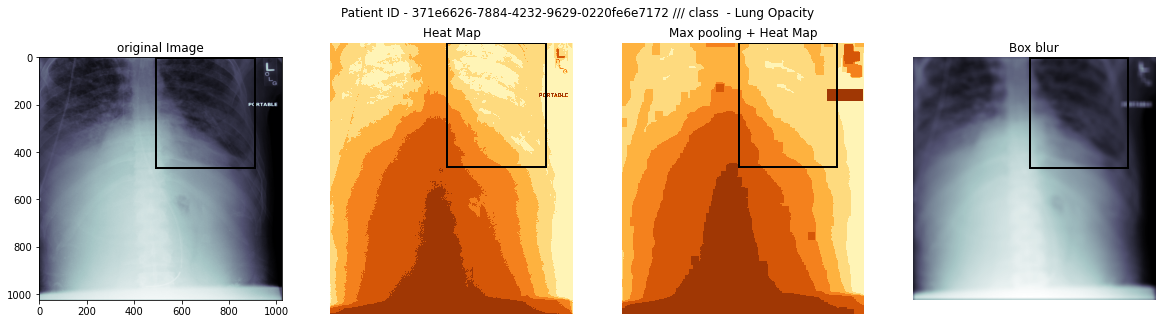

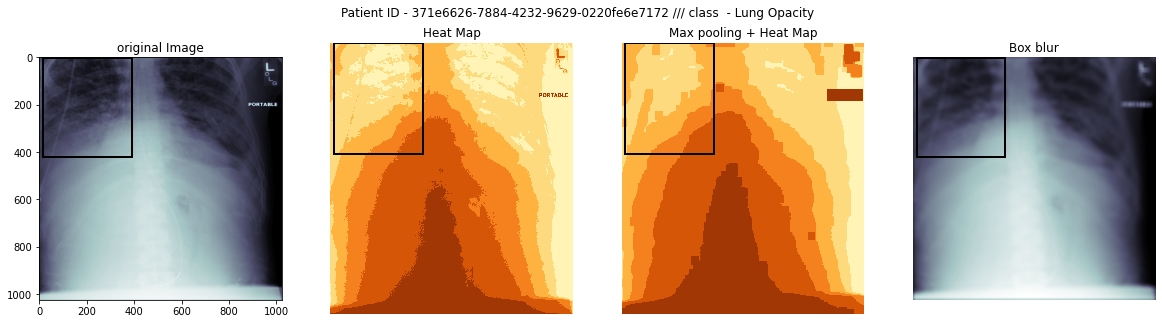

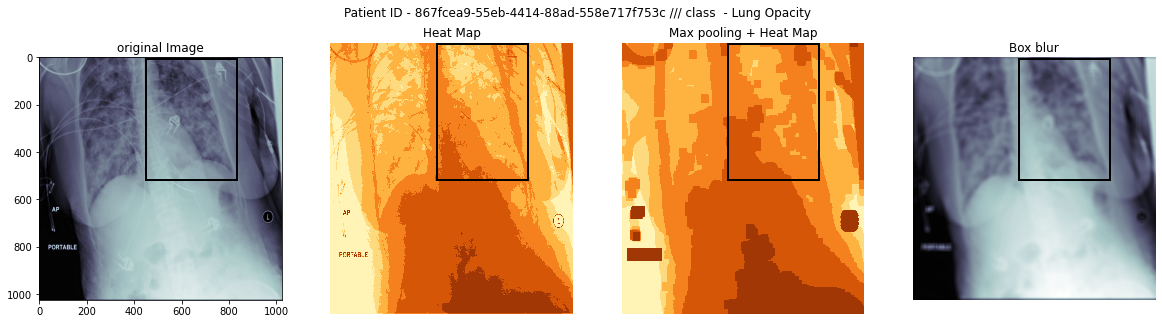

In [92]:
plot_images(train_data.query("y <= 10").index)

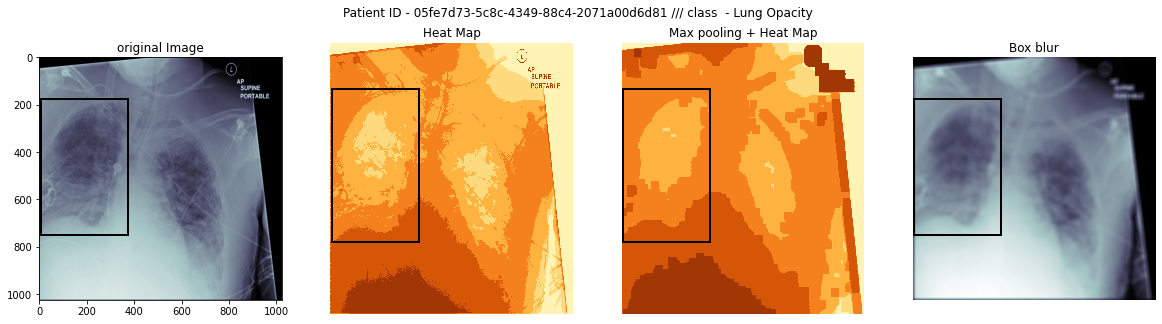

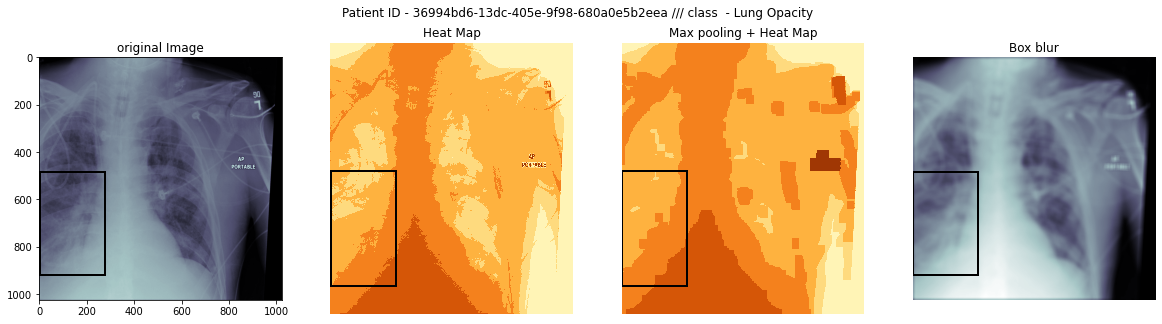

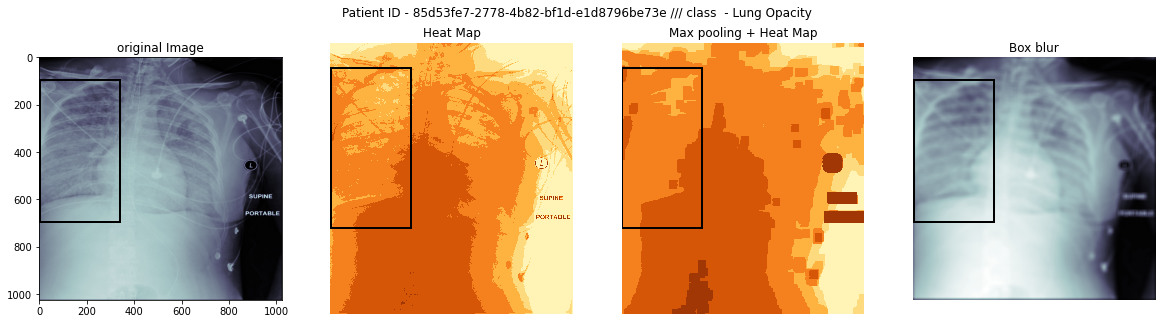

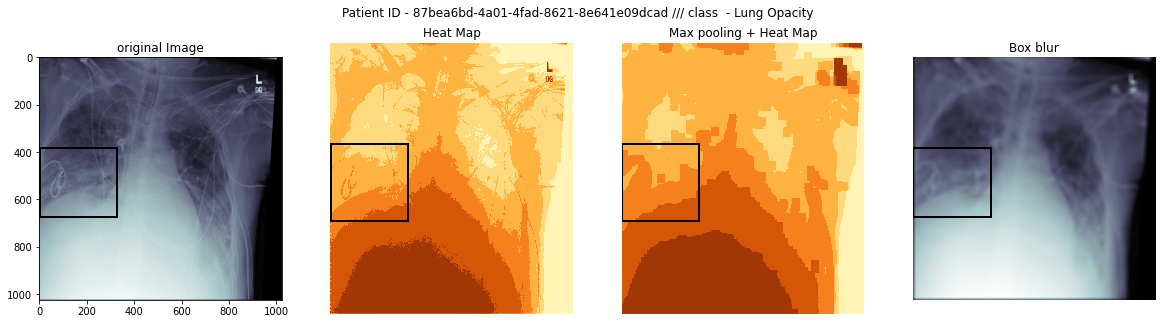

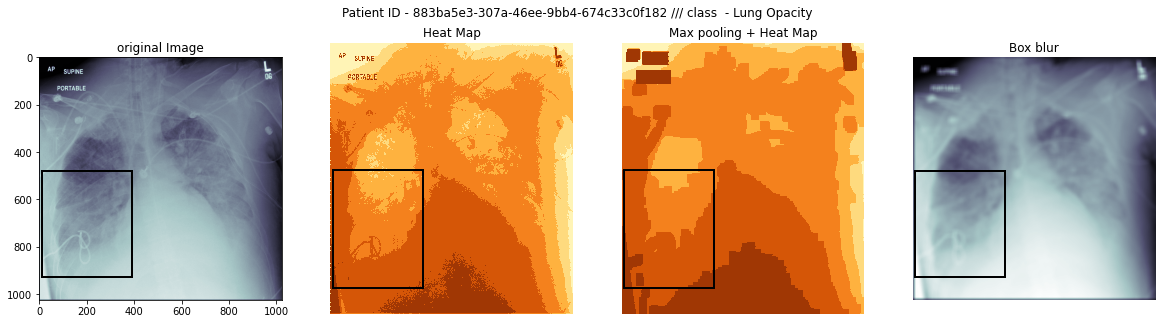

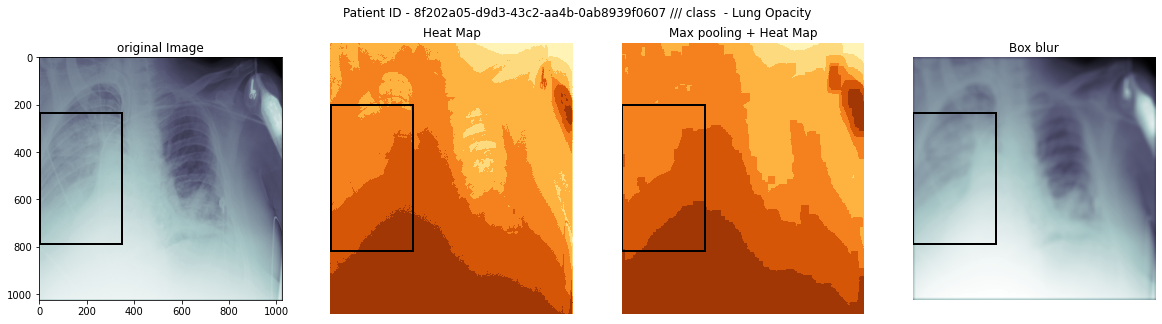

In [93]:
plot_images(train_data.query("x <= 10").index)

#### Age / sex and its correlation with infection

In [79]:
# Visualize the image 
infected_id = train_data.query("Target == 1").sample(n=100).index
not_infected_id = train_data.query("Target == 0").sample(n=100).index



def read_xray_metadata(id_list):
  data_list = []
  for index in id_list:
    file_name = train_data.iloc[index]["filepath"]
    ds = dicom.read_file(file_name)
    data = []
    data.append(ds.PatientID)
    data.append(ds.PatientAge)
    data.append(ds.PatientSex)
    data_list.append(data)
    #print(train_data.iloc[index]["patientId"],ds.PatientID)
  return data_list


result_list = []
result_list.extend(read_xray_metadata(infected_id))
result_list.extend(read_xray_metadata(not_infected_id))

sample_meta_data = pd.DataFrame(result_list,columns=["patientId","age","sex"])
sample_meta_data = sample_meta_data.join(train_data[["patientId","Target"]].drop_duplicates().set_index("patientId"),on="patientId")
print("shape", sample_meta_data.shape)
sample_meta_data.head(20)

shape (200, 4)


patientId age sex  Target
0   9d5b8701-9073-4cac-a1fd-c80a6d1404a7  30   M       0
1   3dd1b743-1aa3-44af-8bfd-5d02e988a7e1  63   M       0
2   341983d7-a04e-4b75-a021-1c5562139301  43   F       1
3   371634ac-fc6c-42d3-9860-e284539921d2  54   M       0
4   c2cb2fa5-31ea-4ff3-8cc7-a3ddf83bfb94  59   F       0
5   71b0ce4b-d1dc-4e08-9e22-be77adec71c1  36   F       0
6   fb7f9d1e-4d67-4ab7-bde9-6e2fe336f197   8   M       0
7   731a748e-a46f-4f53-84d5-0607e4e2cbc7  11   F       0
8   afeacaf9-b9e4-4f0d-a200-17b94ac64b9a  34   M       0
9   1f20a7b4-fc0d-49fa-8cc0-ecd516509372  55   M       1
10  1d6a285a-9c5f-42f6-b17e-667ce5f76fbf  48   M       0
11  3e2db6da-3b64-4388-8098-1c4c037ec03a   6   F       1
12  640675db-2fbc-4aa7-be16-572a540eecf5  65   M       0
13  d614cd4f-8419-48f4-a9c8-cb5282f329ec   6   F       0
14  32f38c16-cd6b-42f0-8a20-68115d2ce57f  65   M       0
15  b630e58a-f0af-4a41-8996-c3c810de841a  55   F       0
16  a4a3fd3c-331e-43d8-8e21-1d9162d34424  48   M       0
17  7863d975-f4da-486d-80ec-2bebc5f8b089  52   M       0
18  bf10ff6e-fc24-4cfc-9b5f-7a156608dc1a  79   M       1
19  5ed4c033-fbe4-42e3-a9f5-6693be3fb2f0  20   M       0

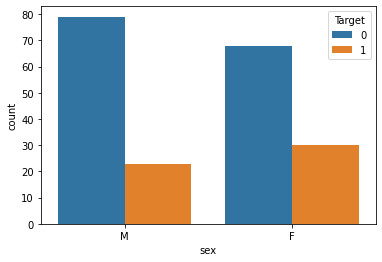

In [80]:
sns.countplot(data=sample_meta_data,x="sex",hue="Target")

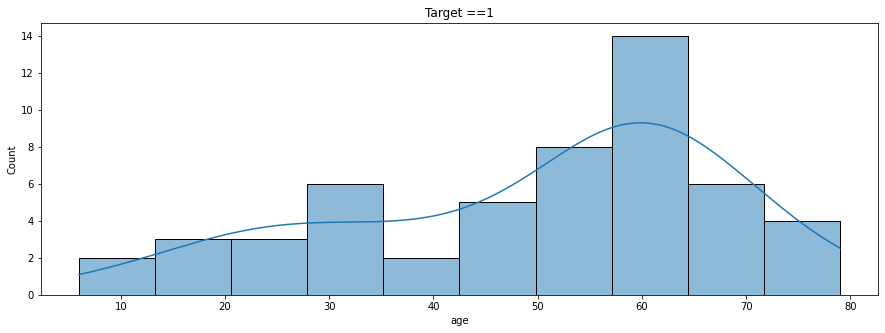

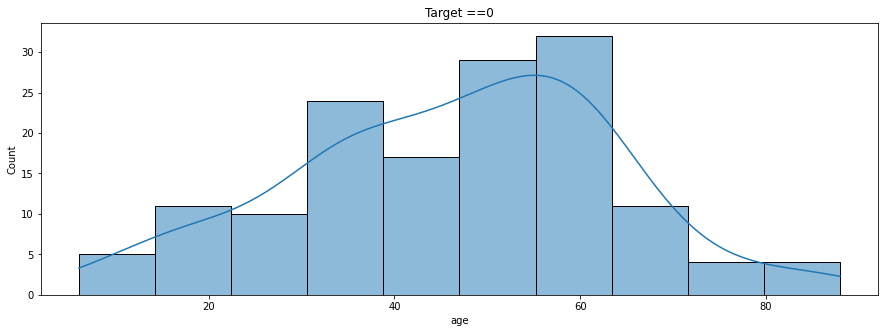

In [94]:
sample_meta_data.age = sample_meta_data.age.astype(int)
sample_meta_data.sort_values(by=["age"],inplace=True)

fig,ax = plt.subplots(figsize=(15,5))
sns.histplot(data = sample_meta_data.query("Target ==1"),x="age",kde=True,ax=ax,bins=10)
plt.title("Target ==1")
plt.show()

fig,ax = plt.subplots(figsize=(15,5))
sns.histplot(data = sample_meta_data.query("Target ==0"),x="age",kde=True,ax=ax,bins=10)
plt.title("Target ==0")
plt.show()


In [95]:
sample_meta_data.corr()

age    Target
age     1.000000  0.081812
Target  0.081812  1.000000

#### Number of infection per Image

(26684, 2)
1    23286
2     3265
3      119
4       14
Name: boxes, dtype: int64


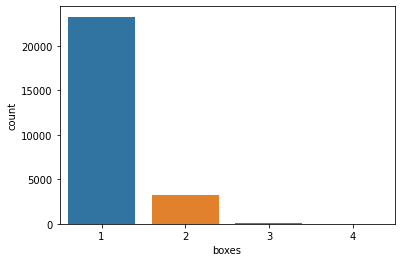

In [91]:
box_df = train_data.groupby('patientId').size().reset_index(name='boxes')
#print(box_df.shape)
print(box_df["boxes"].value_counts())
sns.countplot(data=box_df, x="boxes") 


3000 - afected 3000 - not affected
3000 - train